In [1]:
%load_ext autoreload
%autoreload 2

In [259]:
import sys
import os
import glob
import datetime
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl.settings import SETTINGS
import pudl.extract.ferc1
import pudl.transform.ferc1
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [397]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

## Pull in the large FERC plants data and clean it up a bit

In [122]:
ferc1_engine = pudl.extract.ferc1.connect_db()
ferc1_steam = pd.read_sql('SELECT * FROM f1_steam;', ferc1_engine)
ferc1_steam_clean = pudl.transform.ferc1.clean_plants_ferc1(ferc1_steam)

## Build a processing pipeline for the FERC Plants using new scikit-learn / pandas integration

In [391]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder

ferc_pipe = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('plant_name', Pipeline([
                ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2,10))),
            ]), 'plant_name'),
            
            ('plant_kind_clean', Pipeline([
                ('onehot', OneHotEncoder()),
            ]), ['plant_kind_clean']),
            
            ('type_const_clean', Pipeline([
                ('onehot', OneHotEncoder()),
            ]), ['type_const_clean']),
            
            ('tot_capacity', Pipeline([
                ('scaler', RobustScaler()),
                ('norm', Normalizer())
            ]), ['tot_capacity']),
            
            ('yr_const', Pipeline([
                ('onehot', OneHotEncoder(categories='auto')),
            ]), ['yr_const']),
            
            ('respondent_id', Pipeline([
                ('onehot', OneHotEncoder(categories='auto')),
            ]), ['respondent_id']),
            
            ('row_number', Pipeline([
                ('onehot', OneHotEncoder(categories='auto')),
            ]), ['row_number']),
            
            ('spplmnt_num', Pipeline([
                ('onehot', OneHotEncoder(categories='auto')),
            ]), ['spplmnt_num'])
        ],
        
        transformer_weights={
            'plant_name': 1.0,
            'plant_kind_clean': 1.0,
            'type_const_clean': 0.5,
            'tot_capacity': 0.5,
            'yr_const': 0.5,
            'respondent_id': 1.0,
            'row_number': 0.0,
            'spplmnt_num': 0.0,
        })
    ),
    ('classifier', pudl.transform.ferc1.FERCPlantClassifier(min_sim=0.5, plants_df=ferc1_steam_clean))
])

In [392]:
fpo = ferc_pipe.fit_transform(ferc1_steam_clean)

/home/zane/anaconda3/envs/pudl/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


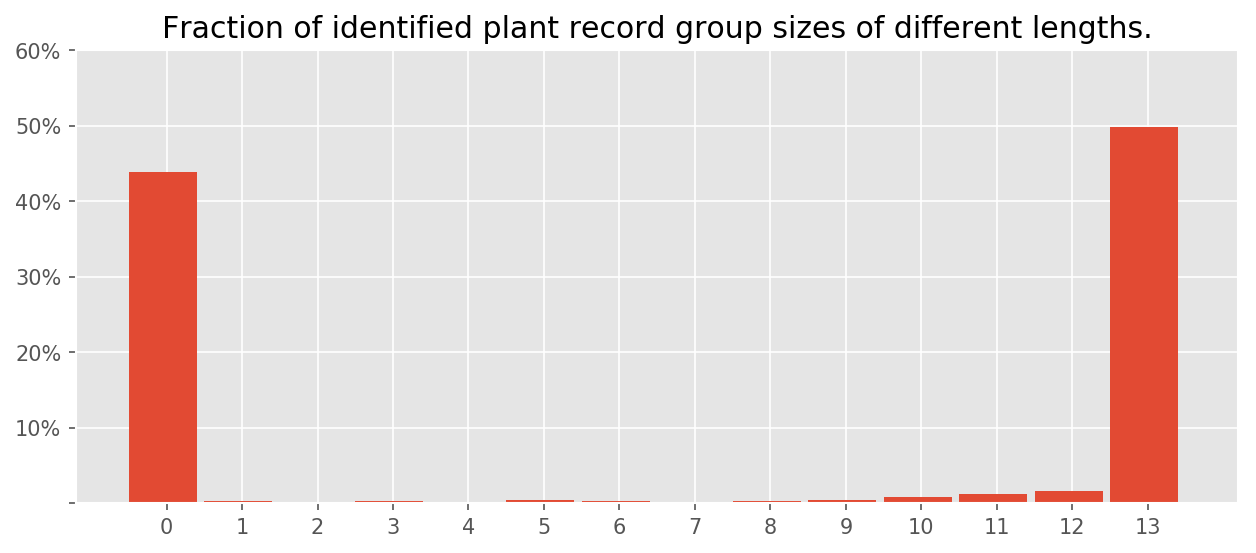

In [398]:
plant_groups = fpo.predict(fpo.best_of_.record_id.values)
plant_group_sizes = pd.Series([len(g) for g in plant_groups])

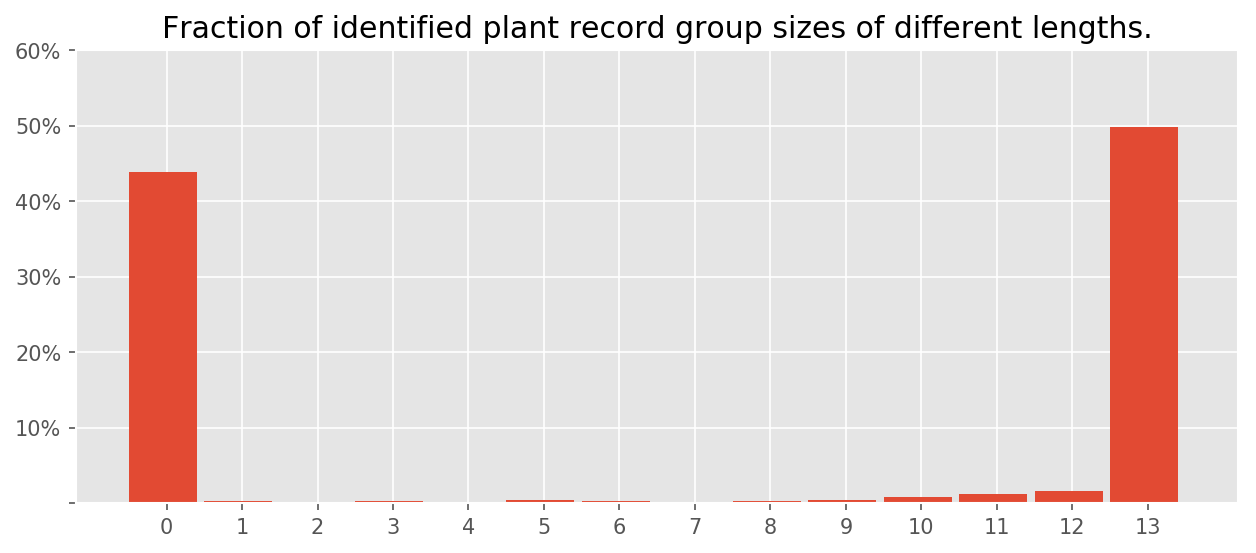

In [399]:
plt.hist(plant_group_sizes, bins=np.arange(-0.5,14.5), density=True, align='mid', width=0.9)
plt.title('Fraction of identified plant record group sizes of different lengths.')
locs, labels = plt.yticks()
plt.yticks(locs, ['','10%', '20%', '30%', '40%', '50%', '60%'])
plt.xticks(np.arange(0,14));

In [400]:
# Create an empty Data Frame in which to collect new interesting training samples
ferc1_years = np.arange(2004,2017)
new_training_groups = pd.DataFrame(columns=ferc1_years)
features = [
    'record_id',
    'report_year',
    'respondent_id',
    'plant_name',
    'plant_kind_clean',
    'type_const_clean',
    'tot_capacity',
    'yr_const'
]

In [428]:
# Select a new potential training sample from our dataframe:
n_recs = -1
n_names = 1
n_resp = 1
#while n_recs < 12 or (n_names < 3 and n_resp < 2):
while n_recs < 12 or n_resp < 2:
    random_group = np.random.choice(plant_groups)
    n_recs = len(random_group)
    random_record = ferc1_steam_clean[ferc1_steam_clean.record_id.isin(random_group)]
    n_names = len(random_record['plant_name'].unique())
    n_resp = len(random_record['respondent_id'].unique())

# Inspect the candidate
random_record[features]

,record_id,report_year,respondent_id,plant_name,plant_kind_clean,type_const_clean,tot_capacity,yr_const
729,2004_27_0_5,2004,27,east bend cge,steam,conventional,461.8,1981
973,2005_27_0_5,2005,27,east bend cge,steam,conventional,447.0,1981
2165,2006_178_0_1,2006,178,east bend,steam,conventional,447.0,1981
3132,2007_178_0_1,2007,178,east bend,steam,conventional,447.0,1981
4490,2008_178_0_1,2008,178,east bend,steam,conventional,447.0,1981
4828,2009_178_0_1,2009,178,east bend,steam,conventional,447.0,1981
6143,2010_178_0_1,2010,178,east bend de ky,steam,conventional,447.0,1981
7060,2011_178_0_1,2011,178,east bend,steam,conventional,447.0,1981
7929,2012_178_0_1,2012,178,east bend,steam,conventional,447.0,1981
8896,2013_178_0_1,2013,178,east bend,steam,conventional,447.0,1981


In [429]:
# Poke around a bit and see if the candidate is really complete / appropriate.
ferc1_steam_clean[
    (ferc1_steam_clean.plant_name.str.match('.*east bend.*'))
    #(ferc1_steam_clean.report_year.isin([2016,]))
    #& (ferc1_steam_clean.respondent_id==120)
][features]
#ferc1_steam[(ferc1_steam.report_year==2004) & (ferc1_steam.respondent_id==41)]

,record_id,report_year,respondent_id,plant_name,plant_kind_clean,type_const_clean,tot_capacity,yr_const
121,2004_42_3_1,2004,42,east bend,other,conventional,207.0,1981
729,2004_27_0_5,2004,27,east bend cge,steam,conventional,461.8,1981
973,2005_27_0_5,2005,27,east bend cge,steam,conventional,447.0,1981
1379,2005_42_3_1,2005,42,east bend,other,conventional,207.0,1981
2124,2006_42_3_1,2006,42,east bend,other,conventional,207.0,1981
2165,2006_178_0_1,2006,178,east bend,steam,conventional,447.0,1981
2984,2007_42_3_1,2007,42,east bend,other,conventional,207.0,1981
3132,2007_178_0_1,2007,178,east bend,steam,conventional,447.0,1981
3975,2008_42_3_1,2008,42,east bend,other,conventional,207.0,1981
4490,2008_178_0_1,2008,178,east bend,steam,conventional,447.0,1981


In [430]:
# If the candidate is good, add it to the accumulation dataframe.
new_group = pd.merge(
    pd.DataFrame(ferc1_years, columns=['report_year']),
    random_record[['report_year', 'record_id']], how='outer'
).fillna('').set_index('report_year').transpose()
new_training_groups = new_training_groups.append(new_group).drop_duplicates().reset_index().drop('index', axis=1)
new_training_groups

report_year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,2004_226_0_1,2005_226_0_1,2006_226_0_1,2007_226_0_1,2008_226_0_1,2009_226_0_1,2010_226_0_1,2011_226_0_1,2012_226_0_1,2013_226_0_1,2014_226_0_1,2015_226_0_1,2016_226_0_1
1,2004_122_0_4,2005_122_0_4,2006_122_0_4,2007_122_0_4,2008_122_0_4,2009_122_0_4,2010_122_0_4,2011_122_0_4,2012_122_0_4,2013_122_0_4,2014_122_0_4,2015_122_0_4,2016_122_0_4
2,2004_89_1_2,2005_89_2_1,2006_89_2_1,2007_89_2_1,2008_89_2_1,2009_89_2_1,2010_89_0_5,2011_89_0_5,2012_89_2_1,2013_89_2_1,2014_89_0_5,2015_89_2_1,2016_89_2_1
3,2004_27_1_5,2005_27_1_5,2006_178_0_3,2007_178_0_3,2008_178_0_3,2009_178_0_3,2010_178_0_3,2011_178_0_3,2012_178_0_3,2013_178_0_3,2014_178_0_3,2015_178_0_3,2016_178_0_3
4,2004_63_0_5,2005_63_1_1,2006_63_0_3,2007_63_0_4,2008_315_0_3,2009_315_0_3,2010_315_0_3,2011_315_0_3,2012_315_0_3,2013_315_0_3,2014_315_0_3,2015_315_0_3,2016_315_0_3
5,2004_63_1_1,2005_63_1_2,2006_63_0_4,2007_63_0_5,2008_315_0_4,2009_315_0_4,2010_315_0_4,2011_315_0_4,2012_315_0_4,2013_315_0_4,2014_315_0_4,2015_315_0_4,2016_315_0_4
6,2004_27_0_5,2005_27_0_5,2006_178_0_1,2007_178_0_1,2008_178_0_1,2009_178_0_1,2010_178_0_1,2011_178_0_1,2012_178_0_1,2013_178_0_1,2014_178_0_1,2015_178_0_1,2016_178_0_1


In [431]:
# Once we've collected enough new records, save them in a CSV file for later use.
dtstr = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
new_training_groups.to_csv(f'ferc1_plant_training_groups_{dtstr}.csv', index=False)

In [434]:
all_training_groups = pd.DataFrame(columns=ferc1_years.astype(str))
# Read all the accumulated training groups into one dataframe
for f in glob.glob('ferc1_plant_training_groups_*.csv'):
    all_training_groups = all_training_groups.append(pd.read_csv(f))
all_training_groups.columns = all_training_groups.columns.astype(int)
all_training_groups = all_training_groups.drop_duplicates().fillna('').reset_index().drop('index', axis=1)
all_training_groups

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,2004_122_1_2,2005_122_1_2,2006_122_1_2,2007_122_1_2,2008_122_1_2,2009_122_1_2,2010_122_1_2,2011_122_1_2,2012_122_1_2,2013_122_1_2,2014_122_1_2,2015_122_1_2,2016_122_1_2
1,2004_276_0_1,2005_276_0_1,2006_276_0_1,2007_276_0_1,2008_276_0_1,2009_276_0_1,2010_276_0_1,2011_276_0_1,2012_276_0_1,2013_276_0_1,2014_276_0_1,2015_276_0_1,2016_276_0_1
2,2004_226_0_1,2005_226_0_1,2006_226_0_1,2007_226_0_1,2008_226_0_1,2009_226_0_1,2010_226_0_1,2011_226_0_1,2012_226_0_1,2013_226_0_1,2014_226_0_1,2015_226_0_1,2016_226_0_1
3,2004_122_0_4,2005_122_0_4,2006_122_0_4,2007_122_0_4,2008_122_0_4,2009_122_0_4,2010_122_0_4,2011_122_0_4,2012_122_0_4,2013_122_0_4,2014_122_0_4,2015_122_0_4,2016_122_0_4
4,2004_89_1_2,2005_89_2_1,2006_89_2_1,2007_89_2_1,2008_89_2_1,2009_89_2_1,2010_89_0_5,2011_89_0_5,2012_89_2_1,2013_89_2_1,2014_89_0_5,2015_89_2_1,2016_89_2_1
5,2004_27_1_5,2005_27_1_5,2006_178_0_3,2007_178_0_3,2008_178_0_3,2009_178_0_3,2010_178_0_3,2011_178_0_3,2012_178_0_3,2013_178_0_3,2014_178_0_3,2015_178_0_3,2016_178_0_3
6,2004_63_0_5,2005_63_1_1,2006_63_0_3,2007_63_0_4,2008_315_0_3,2009_315_0_3,2010_315_0_3,2011_315_0_3,2012_315_0_3,2013_315_0_3,2014_315_0_3,2015_315_0_3,2016_315_0_3
7,2004_63_1_1,2005_63_1_2,2006_63_0_4,2007_63_0_5,2008_315_0_4,2009_315_0_4,2010_315_0_4,2011_315_0_4,2012_315_0_4,2013_315_0_4,2014_315_0_4,2015_315_0_4,2016_315_0_4
8,2004_27_0_5,2005_27_0_5,2006_178_0_1,2007_178_0_1,2008_178_0_1,2009_178_0_1,2010_178_0_1,2011_178_0_1,2012_178_0_1,2013_178_0_1,2014_178_0_1,2015_178_0_1,2016_178_0_1
9,2004_36_0_2,2005_36_0_1,2006_36_0_1,,2008_36_0_1,2009_36_0_1,2010_36_0_1,2011_36_0_1,2012_36_0_1,2013_36_0_1,2014_36_0_1,2015_36_0_1,2016_36_0_1


In [437]:
ferc_pipe.get_params()['preprocessor']

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights={'plant_name': 1.0, 'plant_kind_clean': 1.0, 'type_const_clean': 0.5, 'tot_capacity': 0.5, 'yr_const': 0.5, 'respondent_id': 1.0, 'row_number': 0.0, 'spplmnt_num': 0.0},
         transformers=[('plant_name', Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_rang...s 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True))]), ['spplmnt_num'])])